# Exploratory Data Analysis (EDA) for Modeling Spinal Health with Biomechanical Data

In this project, we will conduct a comprehensive exploratory data analysis (EDA) on the Modeling Spinal Health with Biomechanical dataset. The goal is to:
- Analyze distribution and correlation among biomechanical attributes
- Detect outliers and apply feature scaling or normalization
- Visualize class distributions (if labels are included in dataset)

We wil answer the following questions:
- Which features are most strongly correlated with spinal abnormalities?
- Are any features linearly dependent on others (e.g., sacral slope and pelvic incidence)?
- Do biomechanical measurements cluster differently for normal vs. abnormal cases?
- Are there multicollinearity issues that impact modeling?

## 1. Import Necessary Libraries and Initialize WandB

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

In [25]:
# Initialize WandB for tracking

wandb.init(project='SDS-CP033-SpineScope', job_type='EDA')



In [26]:
# Load the dataset
data = "dataset/column_3C_weka.csv"
dataset = pd.read_csv(data)

In [27]:
# Convert the 'classe' column to a binary encoding: 1 for 'Abnormal', 0 for 'Normal'
def encode_class(uncoded_class):
    if uncoded_class == 'Normal':
        return 0
    elif uncoded_class == 'Abnormal' or uncoded_class == 'Hernia':
        return 1
    elif uncoded_class == 'Spondylolisthesis':
        return 2
    else:
        return f"Unknown class '{uncoded_class}'"

dataset['class_coded'] = dataset['class'].apply(encode_class)
dataset.drop(columns=['class'], inplace=True)  # Drop the original class column
display(dataset.class_coded.value_counts().reset_index())

,class_coded,count
0,2,150
1,0,100
2,1,60


In [28]:
# Log the dataset version to WandB
wandb.log({"data_shape": dataset.shape})
dataset.shape # Visualize the shape of the dataset

(310, 7)

### Saving original dataset to WandB

In [29]:
# Log the original dataset to WandB as an artifact
data_artifact = wandb.Artifact('raw_dataset', type='dataset')
data_artifact.add_file(data, name=f"{data.split('/')[-1].split('.')[0]}")
wandb.log_artifact(data_artifact)

<Artifact raw_dataset>



## 2. Data Overview


In this section, we will load the dataset and conduct an initial exploration to understand the data's structure, including data types, missing values, and basic statistics.


In [30]:
# Display the first few rows of the dataset
display(dataset.head(6))

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class_coded
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,1
5,40.250200,13.921907,25.124950,26.328293,130.327871,2.230652,1


In [31]:
missing_values = dataset.isnull().sum() # Check for missing values
missing_values

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
class_coded                 0
dtype: int64

In [32]:
display(dataset.dtypes) # Display data types

display(dataset.describe()) # Display summary statistics

wandb.log({"data_description": wandb.Table(data=dataset.describe())}) # Log the data_description to WandB

pelvic_incidence            float64
pelvic_tilt                 float64
lumbar_lordosis_angle       float64
sacral_slope                float64
pelvic_radius               float64
degree_spondylolisthesis    float64
class_coded                   int64
dtype: object

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class_coded
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694,1.161290
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027,0.884852
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179,0.000000
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727,0.000000
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934,1.000000
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352,2.000000
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082,2.000000


### Key Observations:
- The data is pretty clean. There are no missing values, and all features are numeric and are all of type 'float64'.
- The dataset is quite small. So, using SMOTE seems like a good option as it adds to the dataset.

## 3. Target Variable Analysis

We will analyze the distribution of the target variable which indicates the patient's condition.

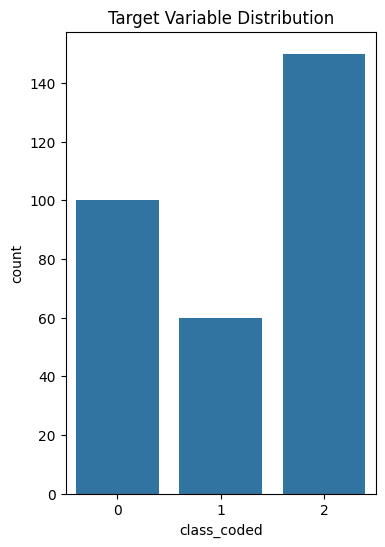

In [33]:
# Analyze the distribution of the target variable
target_distribution = dataset['class_coded'].value_counts(normalize=True).reset_index() # Normalize to get proportions
wandb.log({'Target_distribution': target_distribution.to_dict()}) # Log target distribution to WandB

plt.figure(figsize=(4, 6)) # Set the figure size
sns.countplot(x='class_coded', data=dataset) # Count plot of the target variable
plt.title("Target Variable Distribution") # Title for the plot
plt.savefig("images/target_distribution") # Save the plot as an image
wandb.log({"target_distribution_plot": wandb.Image(plt)}) # Log the distribution plot to WandB
# plt.close() 


### Key Observations:
- In the 2C dataset, the classes are imbalanced as the Abnormal class is more than twice the size of the Normal class. The implications are:
    - **Accuracy** may be misleading. Predicting only "Abnormal" gets \~68%.
    - **Recall/Precision** especially for the minority class ("Normal") — may suffer.
    - The model could be **Bias** toward the majority class.

- The dataset is quite small. So, using SMOTE seems like a good option as it adds to the dataset.


## 4. Numerical Features Analysis and Outlier Detection

Next, we will analyze the distribution and relationships of numerical features. This includes checking for outliers, understanding the distribution, and identifying correlations between features. Identifying and handling outliers is crucial in data preprocessing. Outliers can significantly skew the results of machine learning models. We will use boxplots to visualize outliers in numerical features.

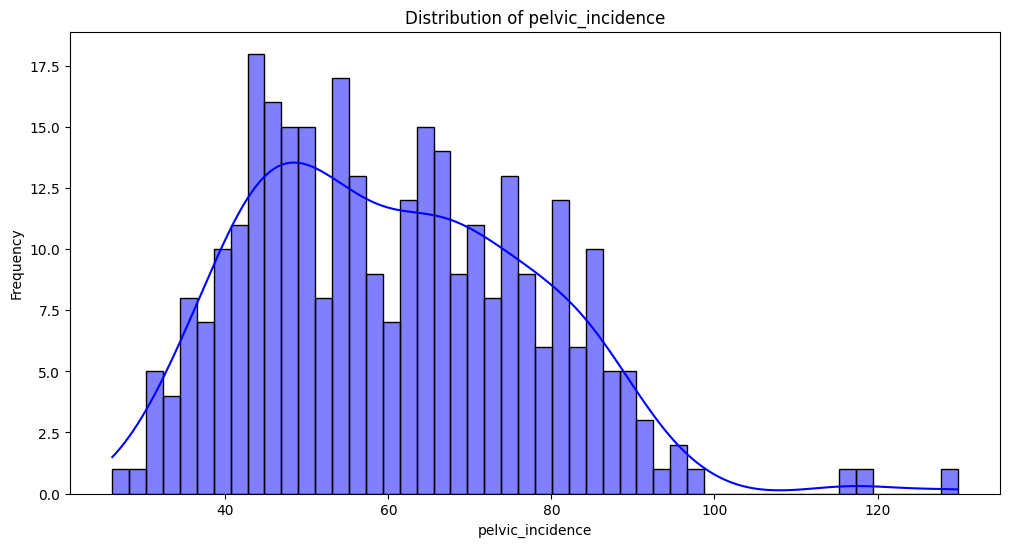

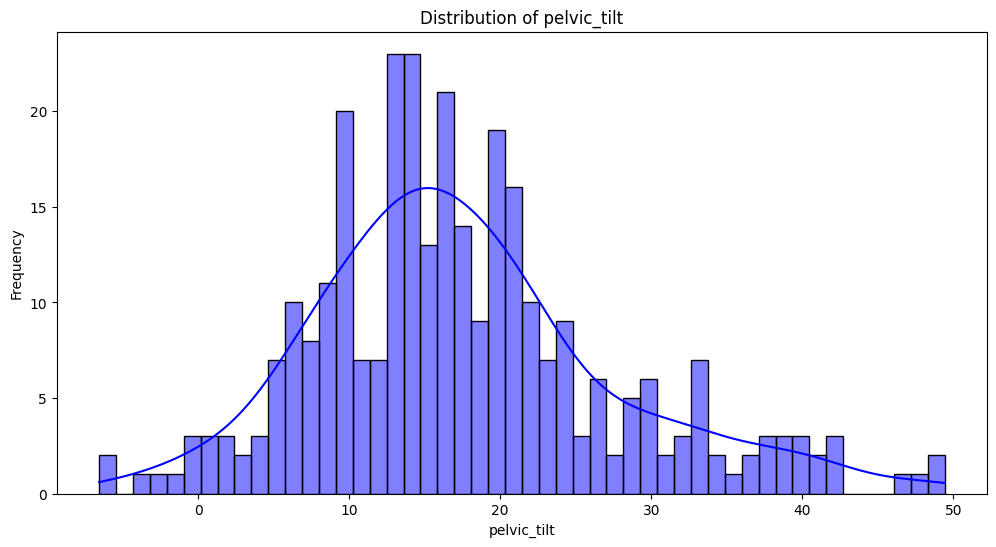

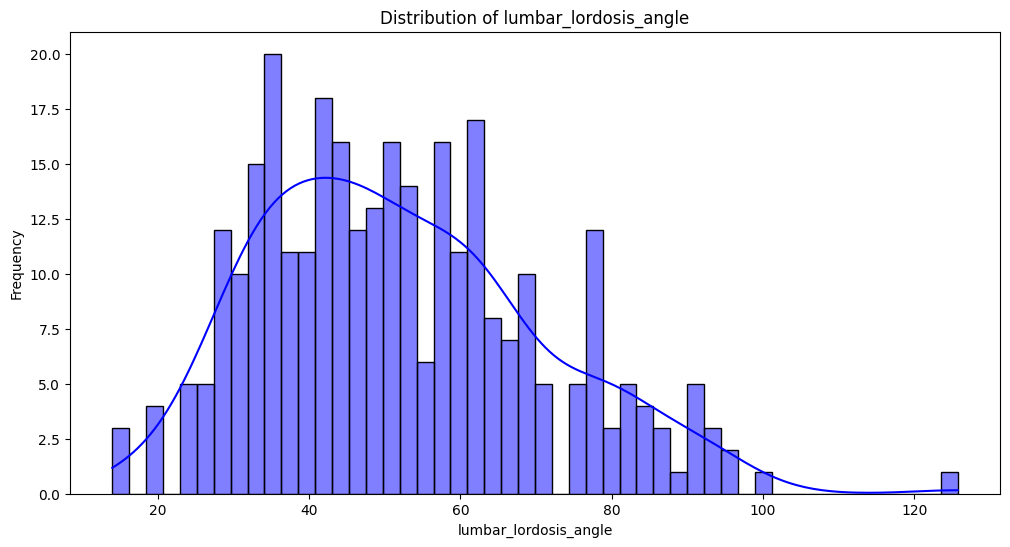

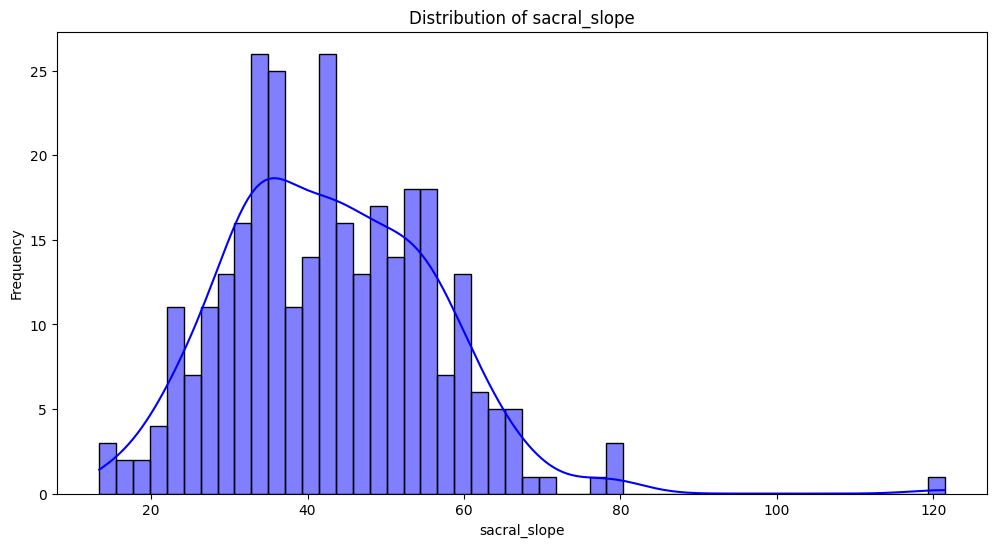

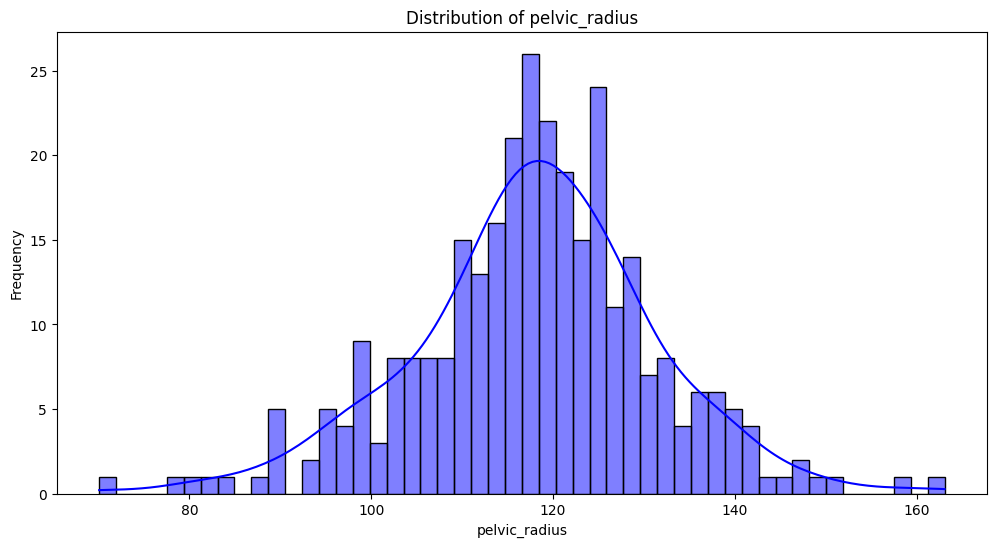

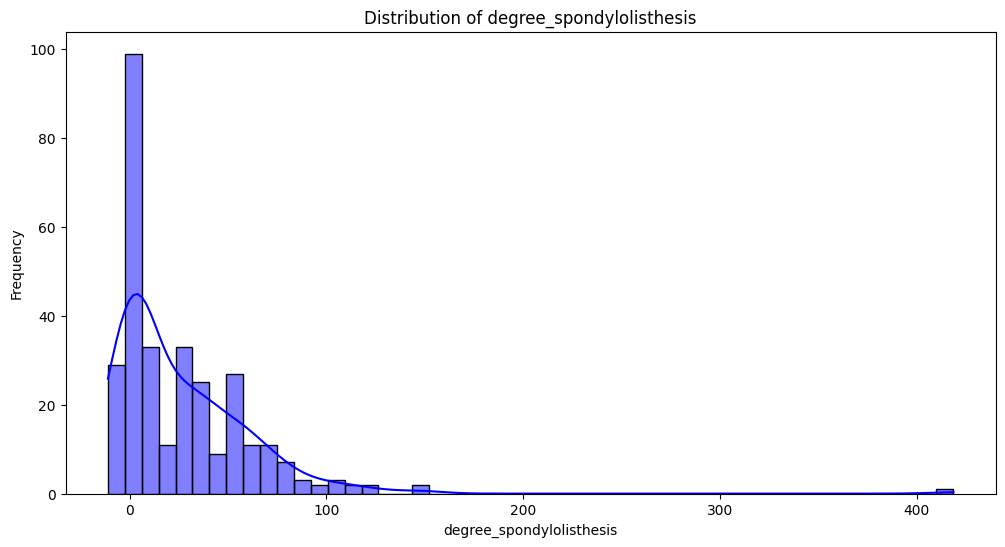

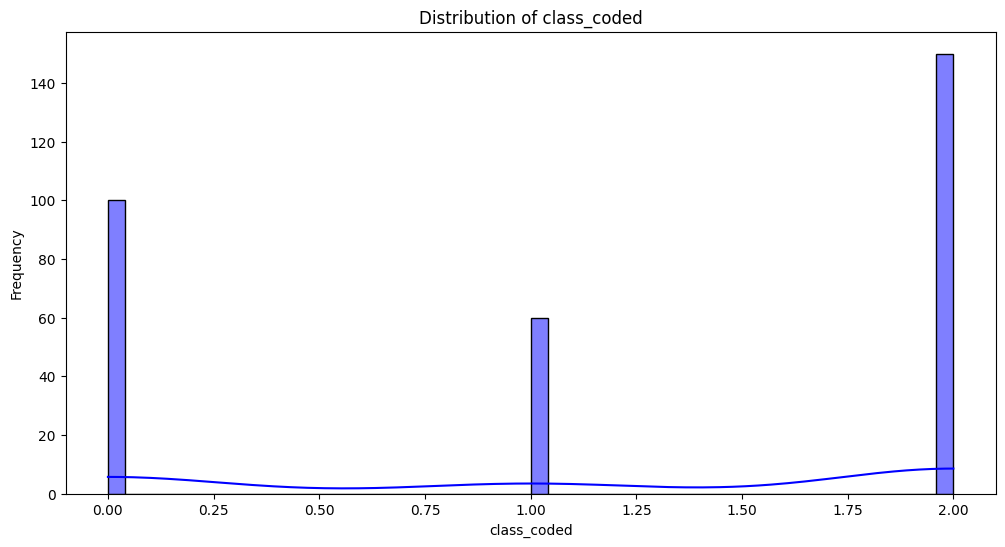

In [34]:
# List of numerical features
num_features = dataset.select_dtypes(include=[np.number]).columns.tolist()

# Plotting distributions
for feature in num_features: # Select numeric features 
    figure_name = f"{feature}_distribution.png"
    plt.figure(figsize=(12,6))
    sns.histplot(dataset[feature], bins=50, kde=True, color='blue')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    wandb.log({figure_name: wandb.Image(plt)}) # Log each distribution plot to WandB
    plt.savefig(f"images/{figure_name}")  # Save the plot as an image
    # plt.close()  # Close the plot to free up memory

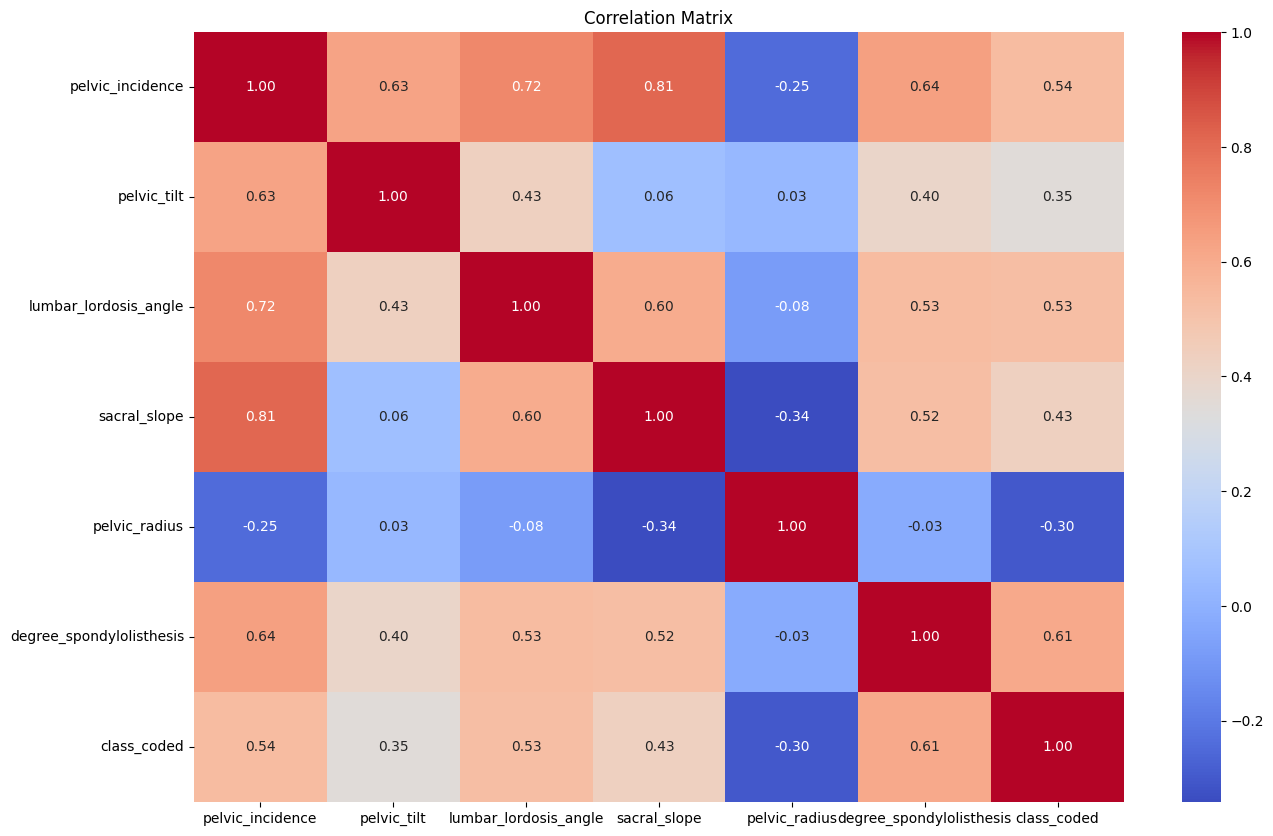

In [35]:
# Compute the correlation matrix
correlation_matrix = dataset.corr(numeric_only=True)

# Plotting the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
wandb.log({"correlation_matrix": wandb.Image(plt)}) # Log correlation matrix to WandB
plt.savefig("images/correlation_matrix") # Save the correlation matrix as an image

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


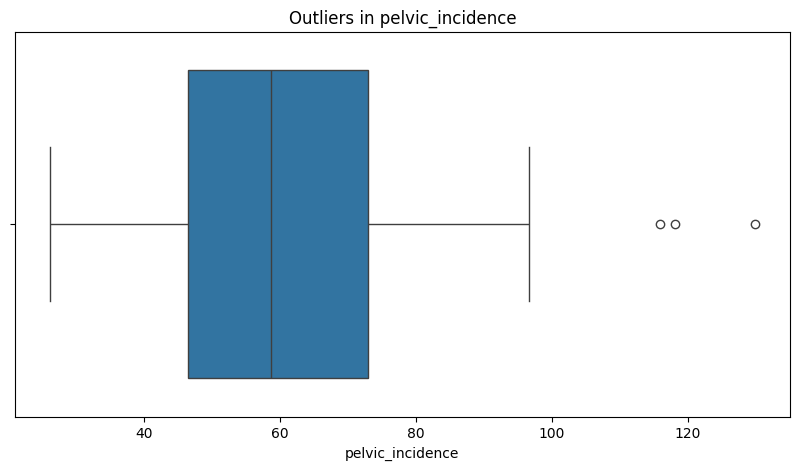

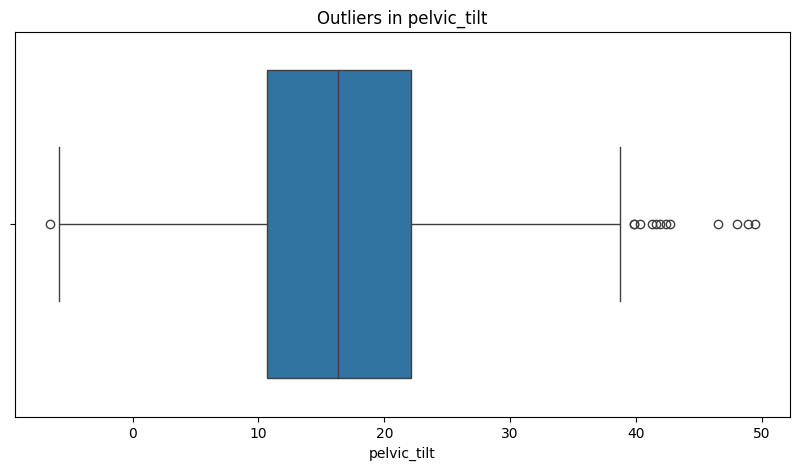

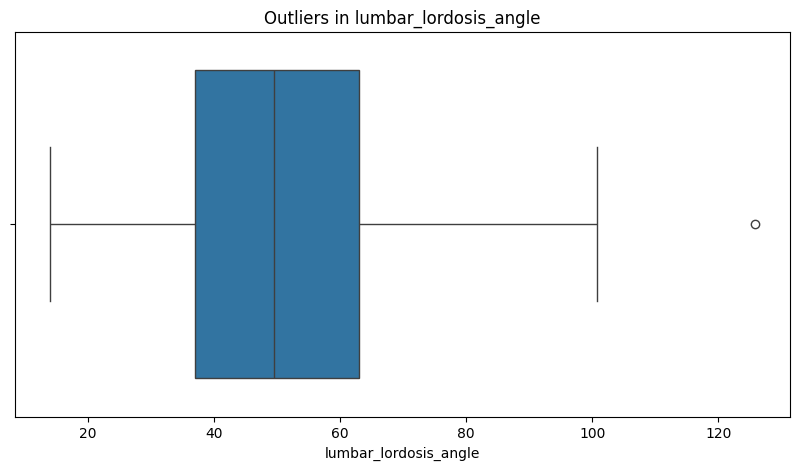

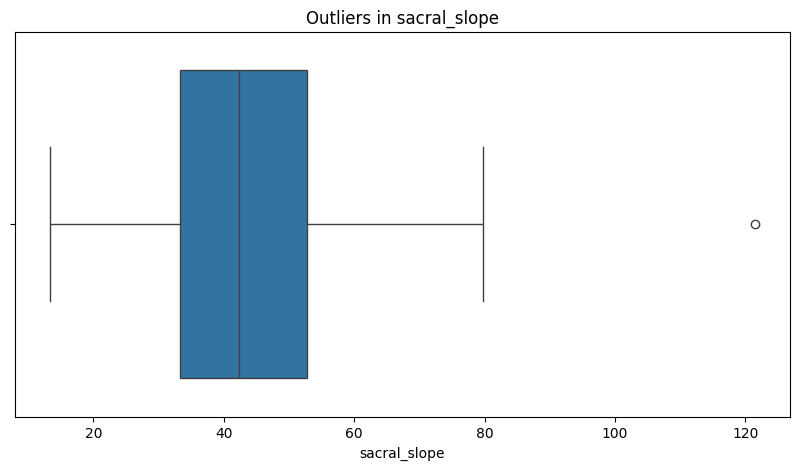

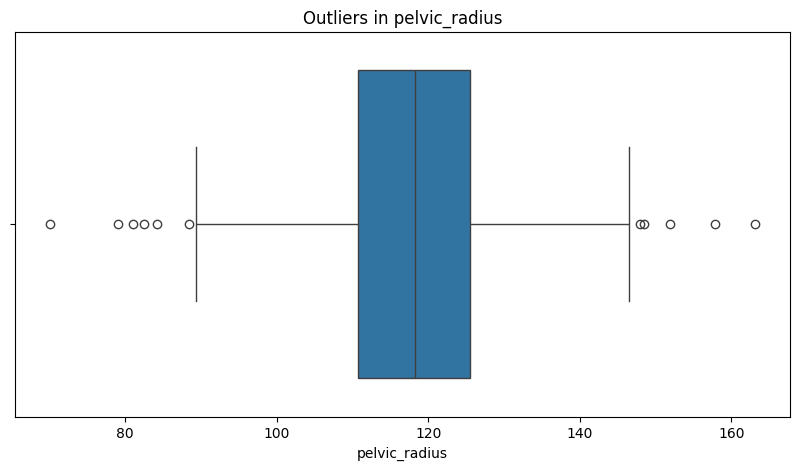

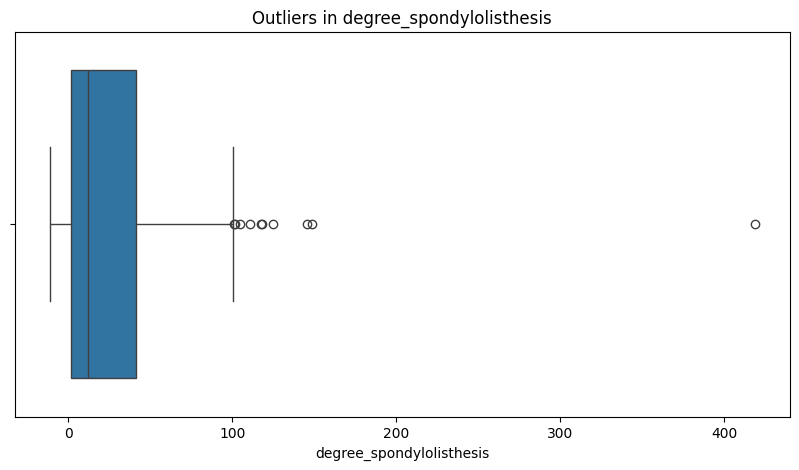

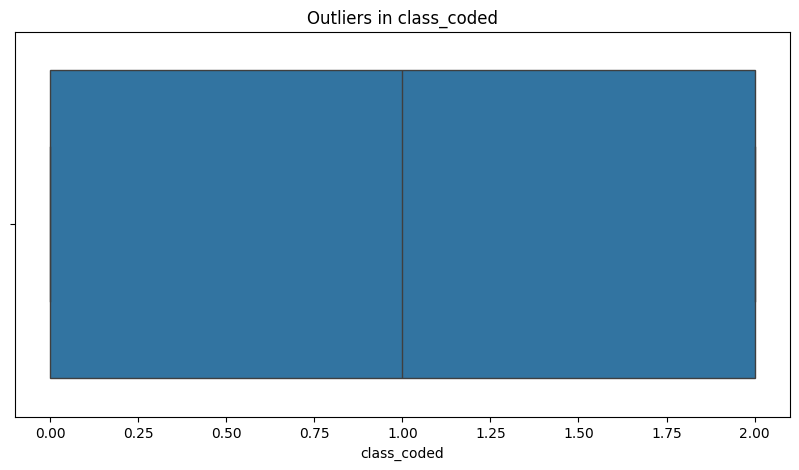

In [36]:
# Identify outliers using boxplots
for feature in num_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=dataset[feature])
    plt.title(f"Outliers in {feature}")
    plt.xlabel(feature)
    plt.savefig(f"images/{feature}_outliers")  # Save the plot as an image
    wandb.log({f"{feature}_outliers": wandb.Image(plt)}) # Log outlier detection to WandB

wandb.finish() # Finish the WandB run

### Key Observations:

- There seem to be some distributions that hints at outliers. However, the histograms has a smooth density with no major gaps or spikes, suggesting a good sample size and no binning issues.

- Strong Feature-to-Feature Correlations:

    - pelvic_incidence ↔ sacral_slope: (0.81) Very strong positive correlation — may be redundant; consider removing one if you're using linear models.
    - pelvic_incidence ↔ lumbar_lordosis_angle: (0.72) Strong positive relationship — could indicate biomechanical dependency.
    - sacral_slope ↔ lumbar_lordosis_angle: (0.60) Also strong; all three might represent related anatomical features.

- Feature–Target (class_coded) Relationships:
    - degree_spondylolisthesis: (0.61) Strongest correlation with the target — very likely important for classification.
    - pelvic_incidence: (0.54), lumbar_lordosis_angle: (0.53), sacral_slope: (0.43) - These all show moderate-to-strong correlation with the class label — useful predictors.
    - pelvic_tilt: (0.35) Moderate — potentially useful.
    - pelvic_radius: (-0.30) Moderate negative correlation — may still be valuable, especially for models that capture interactions (trees, ensembles).

- Multicollinearity Considerations
    - Several features have pairwise correlations > 0.7, which may cause issues in models like:
        - Logistic regression
        - Linear regression
        - SVM with linear kernel
    - Suggestion: Consider using PCA, feature selection, or regularization (e.g., L1/Lasso) to deal with multicollinearity.

- Recommendations:
    - Keep degree_spondylolisthesis as it has the strongest correlation with target
    - Despite correlation, pelvic_incidence, lumbar_lordosis_angle, sacral_slope are the strong predictors
    - Because of their very highly correlated (0.81), we will consider dropping or reducing multicollinearity	pelvic_incidence or sacral_slope
    - The negative correlation of	pelvic_radius to the class_coded is worth investigating. Ir is possibly less relevant but worth testing
    - If we are to use all features, we will need to use tree-based models to handle multicollinearity and nonlinear effects naturally



